# Kaggle Cats versus Dogs Redux
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

Binary image classification of cat and dog images to evaluate varying convolutional neural networks

In [150]:
# Import dependencies
import os
from os import listdir, makedirs
import os.path
import re
import gc
# print(os.listdir("input"))

# Organize dataset into a useful structure
from shutil import copyfile
from random import seed
import random

import keras
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard

import cv2
import time 
import numpy as np
from numpy import asarray
from numpy import save
import pandas as pd
import datetime
from random import shuffle
from tqdm import tqdm

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from keras.layers import BatchNormalization
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

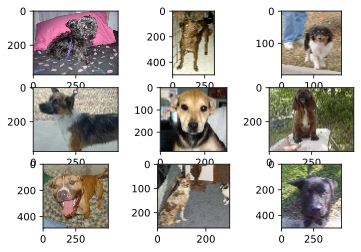

In [2]:
# Examine some sample dog photos
# Define location of dataset
folder = 'input/train/'

# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)

    # show the figure
plt.show()

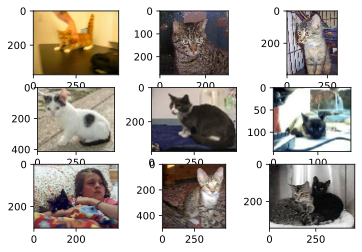

In [3]:
# Examine some sample cat photos
# Define location of dataset
folder = 'input/train/'

# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)

    # show the figure
plt.show()

In [4]:
# Store images
TRAIN_DIR = 'input/train/'
TEST_DIR = 'input/test/'

# Image size
img_width = 224
img_height = 224

train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [5]:
# Sort image files function
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [6]:
# Sort images and select sub-set for training
train_images_dogs_cats.sort(key=natural_keys)
train_images_dogs_cats = train_images_dogs_cats[0:1300] + train_images_dogs_cats[12500:13800] 
test_images_dogs_cats.sort(key=natural_keys)

In [25]:
# Data preparation function - arrays
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
        #else:
            #print('neither cat nor dog name present in images')
            
    return x, y

In [26]:
# Prepare training data
X, Y = prepare_data(train_images_dogs_cats)
print(K.image_data_format())

channels_last


In [48]:
# Split the data into two sets, 80% for training, 20% for validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

del X
del Y
gc.collect()

X_train = np.array(X_train)
X_val = np.array(X_val)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

train_size = X_train.shape[0]
val_size = X_val.shape[0]

print("Train and validation shapes")
print("X_train: " + str(X_train.shape))
print("X_val: " + str(X_val.shape))
print("y_train: " + str(Y_train.shape))
print("y_val: " + str(Y_val.shape))

Train and validation shapes
X_train: (2080, 224, 224, 3)
X_val: (520, 224, 224, 3)
y_train: (2080,)
y_val: (520,)


In [29]:
# Prepare test data
X_test, _ = prepare_data(test_images_dogs_cats)

X_test = np.array(X_test).astype('float32') / 255
    
print("Test dataset shape: ")
print(X_test.shape)

Test dataset shape: 
(12500, 224, 224, 3)


# Model definitions

In [50]:
# Set CNN hyperparameters
batch_size = 16
num_clases = 1
epochs = 10
conv_kernel_size = 3
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

# CNN fine tuning 
default_dropout_rate = 0.2
regularizaion_weight = 0.001
learning_rate_reduction_factor = 0.5

# Data parameters
img_width = 224
img_height = 224
validation_size = 0.2

In [33]:
# Callbacks

# add before model fit
# checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_model_1.h5",
#                                                 save_best_only=True)
early_stopping = EarlyStopping(patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)

callbacks = [checkpoint_cb, early_stopping, learning_rate_reduction]

In [42]:
# Model 1: 6 layers with dropout regularization
# Model definition
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(32, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_24 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 64)       

In [43]:
# Model 2: 6 layers with dropout regularization and batch normalization
# Model definition
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_28 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_29 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 64)       

In [44]:
# Model 3: 8 layers with dropout regularization
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Flatten())
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_33 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_34 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 52, 52, 64)       

In [45]:
# Model 4: 8 layers with dropout regularization and batch normalization
model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(64, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(64, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Flatten())
model_4.add(Dense(64))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

model_4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_39 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_40 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 52, 52, 64)       

In [38]:
# Data augmentation/transformations with shearing, zooming, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [39]:
# Prepare generators
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

# Model 1 evaluation

In [53]:
# Fit the model
start_time = time.time()
history = model_1.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,    
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks,
    verbose=2)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'keras_cnn_model_1.h5'
model_path = os.path.join(save_dir, model_name)
model_1.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

# # Final evaluation of the model
# # Loading saved model
# mnist_model = load_model('results/keras_mnist_model_4.h5')
# scores = mnist_model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/10
 - 65s - loss: 0.3292 - accuracy: 0.8663 - val_loss: 0.5063 - val_accuracy: 0.7812
Epoch 2/10
 - 65s - loss: 0.3162 - accuracy: 0.8668 - val_loss: 0.5641 - val_accuracy: 0.7897
Epoch 3/10
 - 65s - loss: 0.3210 - accuracy: 0.8639 - val_loss: 0.2594 - val_accuracy: 0.7897
Epoch 4/10
 - 65s - loss: 0.3310 - accuracy: 0.8591 - val_loss: 0.4231 - val_accuracy: 0.7798

Epoch 00004: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 5/10
 - 65s - loss: 0.3027 - accuracy: 0.8721 - val_loss: 0.3913 - val_accuracy: 0.7956
Epoch 6/10
 - 393s - loss: 0.3089 - accuracy: 0.8721 - val_loss: 0.3731 - val_accuracy: 0.7738
Epoch 7/10
 - 66s - loss: 0.3022 - accuracy: 0.8721 - val_loss: 0.2819 - val_accuracy: 0.7817

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 8/10
 - 65s - loss: 0.3009 - accuracy: 0.8740 - val_loss: 0.3293 - val_accuracy: 0.7659
--------------------------
Training time in seconds:  850.39
-------------------------

In [54]:
# Final evaluation of the model
scores = model_1.evaluate(validation_generator, verbose=0)
print('Testing scores:')
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Accuracy score: %.4f" % scores[1])
print("Loss: %.4f" % scores[0])

Testing scores:
Accuracy score: 0.7942
Loss: 0.6020


**Figure 1: Model 1 learning curves**

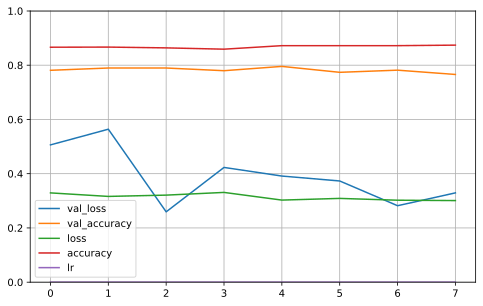

In [55]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**Figure 2: Model 1 learning curves**

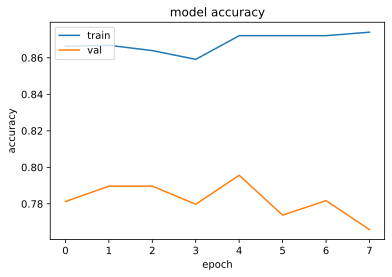

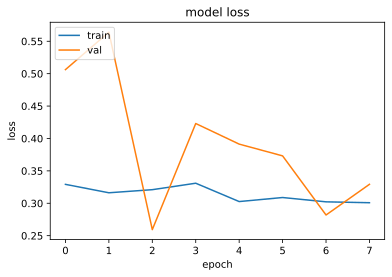

In [63]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Kaggle submission

In [139]:
# Predict on test data
predictions = model_1.predict(X_test, verbose=0)

In [64]:
ids = range(1, len(X_test) + 1)
solution = pd.DataFrame({"id": ids, "label":list(predictions)})
cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
solution.to_csv("results/Sunday_CNN_1.csv", index = False)

Kaggle ID: clairence<br>
Kaggle score: 0.54824

<img src="CNN1.png">

**Figure 3: Model 1 test predictions**

I am 88.65% sure this is a Dog


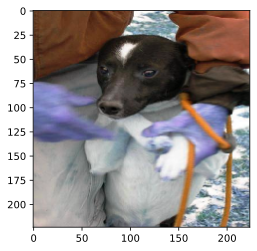

I am 99.09% sure this is a Dog


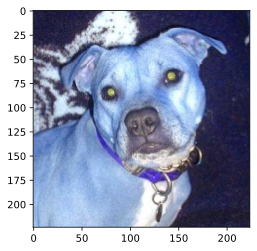

I am 99.60% sure this is a Cat


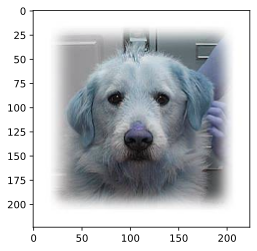

I am 100.00% sure this is a Dog


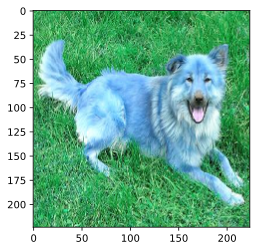

I am 99.99% sure this is a Cat


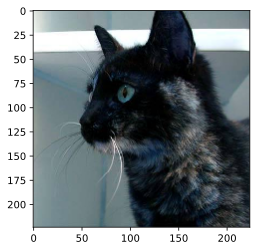

I am 50.37% sure this is a Dog


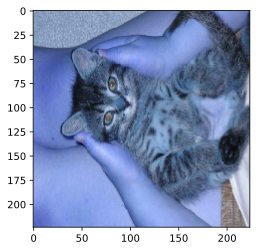

I am 99.17% sure this is a Cat


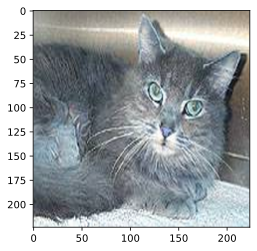

I am 78.29% sure this is a Dog


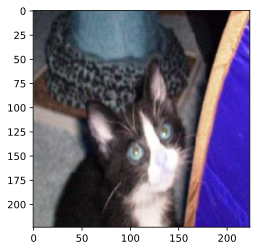

I am 99.91% sure this is a Cat


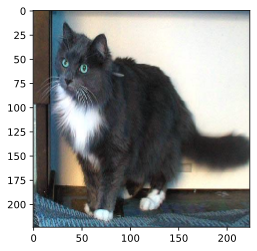

I am 64.57% sure this is a Cat


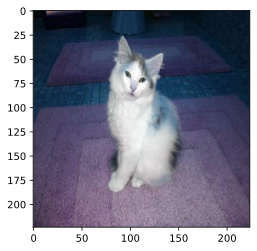

In [144]:
# Test out some predictions
predictions = model_1.predict(X_test, verbose=0)

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow((X_test[i]))
    plt.show()

# Model 2 evaluation

In [77]:
# Fit the model
# model = model()
start_time = time.time()
history = model_2.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,    
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks,
    verbose=2)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'keras_cnn_model_2.h5'
model_path = os.path.join(save_dir, model_name)
model_2.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

# # Final evaluation of the model
# # Loading saved model
# mnist_model = load_model('results/keras_mnist_model_4.h5')
# scores = mnist_model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/10
 - 76s - loss: 0.7926 - accuracy: 0.5495 - val_loss: 0.9137 - val_accuracy: 0.5156
Epoch 2/10
 - 74s - loss: 0.7203 - accuracy: 0.5976 - val_loss: 0.6096 - val_accuracy: 0.6488
Epoch 3/10
 - 72s - loss: 0.6566 - accuracy: 0.6264 - val_loss: 0.9655 - val_accuracy: 0.5337
Epoch 4/10
 - 73s - loss: 0.6396 - accuracy: 0.6433 - val_loss: 0.7881 - val_accuracy: 0.5774

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
 - 71s - loss: 0.5759 - accuracy: 0.7019 - val_loss: 0.5717 - val_accuracy: 0.6845
Epoch 6/10
 - 74s - loss: 0.5636 - accuracy: 0.7091 - val_loss: 0.6966 - val_accuracy: 0.6925
Epoch 7/10
 - 77s - loss: 0.5426 - accuracy: 0.7317 - val_loss: 0.6199 - val_accuracy: 0.7202
Epoch 8/10
 - 72s - loss: 0.5223 - accuracy: 0.7587 - val_loss: 0.5095 - val_accuracy: 0.7302
Epoch 9/10
 - 75s - loss: 0.5156 - accuracy: 0.7543 - val_loss: 0.4833 - val_accuracy: 0.6587
Epoch 10/10
 - 80s - loss: 0.5114 - accuracy: 0.7620 - val_loss: 0.5507 -

In [78]:
# Final evaluation of the model
scores = model_2.evaluate(validation_generator, verbose=0)
print('Testing scores:')
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Accuracy score: %.4f" % scores[1])
print("Loss: %.4f" % scores[0])

Testing scores:
Accuracy score: 0.7038
Loss: 0.3590


**Figure 4: Model 2 learning curves**

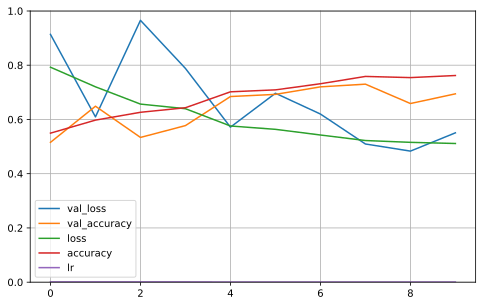

In [79]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**Figure 5: Model 2 learning curves**

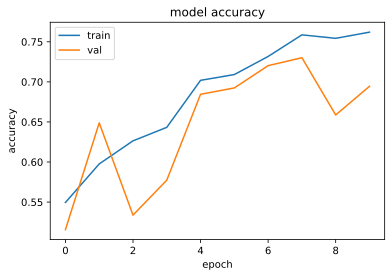

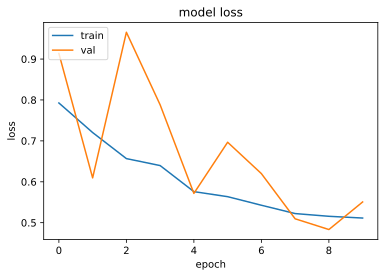

In [80]:
# Visualize results
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
# # Test out some images
# # Test on sample images
# # Preprocess test dataset showcase with predictions
# for i in range(0, 60, 6): 
#     plot_data(X_test[i:], predictions[i:], 6)

In [58]:
# image = X_train[0]
# test_pred = model_1.predict_classes(image.reshape(1, 64, 64, 3))

# show_images(X_train, Y_train, 0)

# print("Model 1 prediction: {}".format(test_pred))

In [60]:
# X_test_lr, test_idx = X_test, test_idx

# for i in np.random.randint(0, len(X_test_lr), 10) :
#   show_image_prediction(X_test_lr, i, model9)


# Kaggle submission

In [81]:
# Predict on test data
predictions = model_2.predict(X_test, verbose=0)

In [82]:
ids = range(1, len(X_test) + 1)
solution = pd.DataFrame({"id": ids, "label":list(predictions)})
cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
solution.to_csv("results/Sunday_CNN_2.csv", index = False)

Kaggle ID: clairence<br>
Kaggle score: 0.54181

<img src="CNN2.png">

**Figure 6: Model 2 test predictions**

I am 68.31% sure this is a Dog


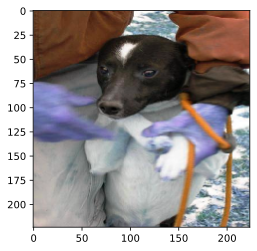

I am 95.74% sure this is a Dog


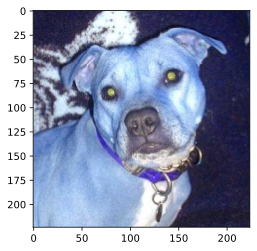

I am 71.75% sure this is a Cat


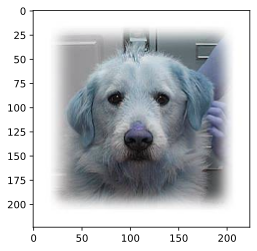

I am 99.72% sure this is a Dog


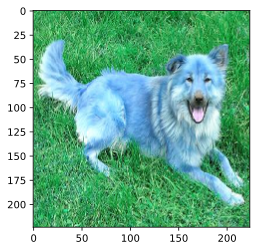

I am 81.16% sure this is a Cat


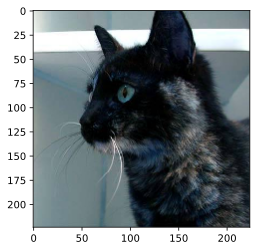

I am 67.90% sure this is a Dog


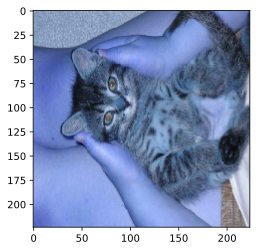

I am 72.15% sure this is a Cat


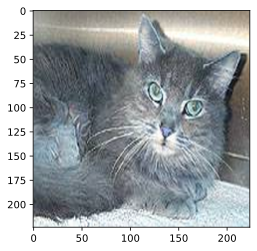

I am 90.06% sure this is a Dog


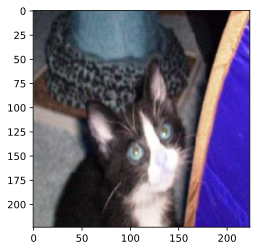

I am 68.29% sure this is a Cat


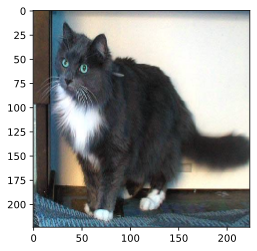

I am 62.29% sure this is a Dog


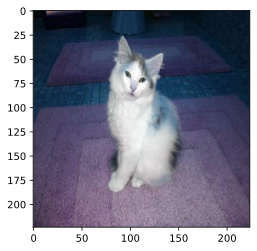

In [147]:
# Test out some predictions
predictions = model_2.predict(X_test, verbose=0)

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow((X_test[i]))
    plt.show()

# Model 3 evaluation

In [83]:
# Fit the model
# model = model()
start_time = time.time()
history = model_3.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,    
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks,
    verbose=2)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'keras_cnn_model_3.h5'
model_path = os.path.join(save_dir, model_name)
model_3.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

# # Final evaluation of the model
# # Loading saved model
# mnist_model = load_model('results/keras_mnist_model_4.h5')
# scores = mnist_model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/10
 - 83s - loss: 0.6994 - accuracy: 0.5207 - val_loss: 0.6671 - val_accuracy: 0.4961
Epoch 2/10
 - 73s - loss: 0.6812 - accuracy: 0.5851 - val_loss: 0.5704 - val_accuracy: 0.6151
Epoch 3/10
 - 77s - loss: 0.6655 - accuracy: 0.6159 - val_loss: 0.5370 - val_accuracy: 0.6607
Epoch 4/10
 - 72s - loss: 0.6380 - accuracy: 0.6625 - val_loss: 0.6405 - val_accuracy: 0.6607
Epoch 5/10
 - 69s - loss: 0.6234 - accuracy: 0.6538 - val_loss: 0.5933 - val_accuracy: 0.6786
Epoch 6/10
 - 89s - loss: 0.5993 - accuracy: 0.6899 - val_loss: 0.6624 - val_accuracy: 0.6806
Epoch 7/10
 - 72s - loss: 0.5900 - accuracy: 0.6981 - val_loss: 0.5302 - val_accuracy: 0.6964
Epoch 8/10
 - 72s - loss: 0.5705 - accuracy: 0.7048 - val_loss: 0.5829 - val_accuracy: 0.6885
Epoch 9/10
 - 71s - loss: 0.5647 - accuracy: 0.7168 - val_loss: 0.5637 - val_accuracy: 0.6627

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/10
 - 73s - loss: 0.4966 - accuracy: 0.7659 - val_loss: 0.2829 -

In [84]:
# Final evaluation of the model
scores = model_3.evaluate(validation_generator, verbose=0)
print('Testing scores:')
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Accuracy score: %.4f" % scores[1])
print("Loss: %.4f" % scores[0])

Testing scores:
Accuracy score: 0.7712
Loss: 0.2957


**Figure 7: Model 3 learning curves**

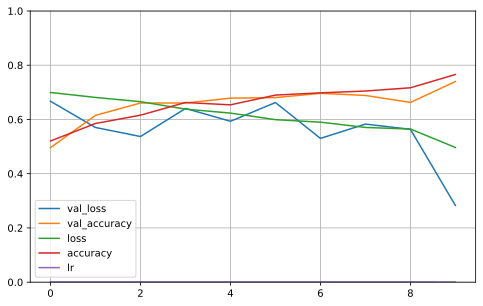

In [85]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**Figure 8: Model 3 learning curves**

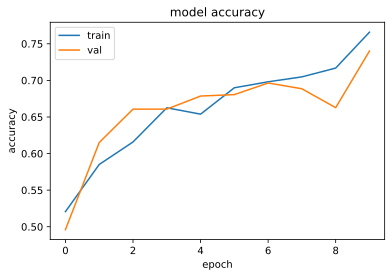

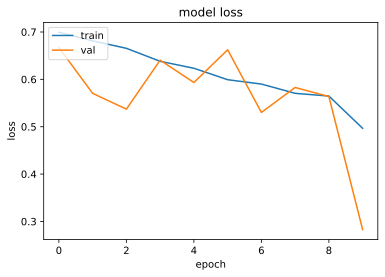

In [86]:
# Visualize results
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
# # Test out some images
# # Test on sample images
# # Preprocess test dataset showcase with predictions
# for i in range(0, 60, 6): 
#     plot_data(X_test[i:], predictions[i:], 6)

In [58]:
# image = X_train[0]
# test_pred = model_1.predict_classes(image.reshape(1, 64, 64, 3))

# show_images(X_train, Y_train, 0)

# print("Model 1 prediction: {}".format(test_pred))

In [60]:
# X_test_lr, test_idx = X_test, test_idx

# for i in np.random.randint(0, len(X_test_lr), 10) :
#   show_image_prediction(X_test_lr, i, model9)


# Kaggle submission

In [87]:
# Predict on test data
predictions = model_3.predict(X_test, verbose=0)

In [88]:
ids = range(1, len(X_test) + 1)
solution = pd.DataFrame({"id": ids, "label":list(predictions)})
cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
solution.to_csv("results/Sunday_CNN_3.csv", index = False)

Kaggle ID: clairence<br>
Kaggle score: 0.51667

<img src="CNN3.png">

**Figure 9: Model 3 test predictions**

I am 79.10% sure this is a Dog


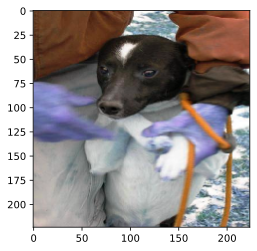

I am 98.30% sure this is a Dog


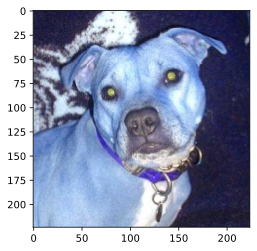

I am 71.57% sure this is a Cat


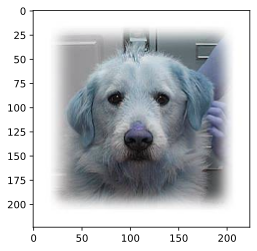

I am 100.00% sure this is a Dog


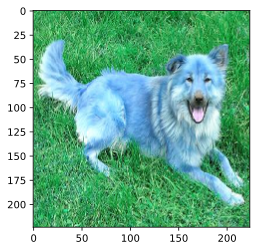

I am 93.03% sure this is a Cat


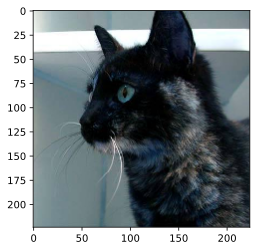

I am 76.83% sure this is a Dog


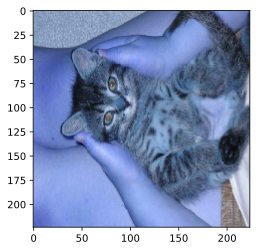

I am 76.91% sure this is a Cat


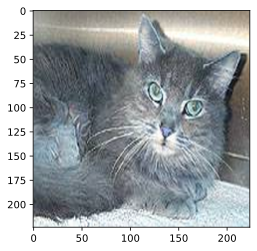

I am 58.86% sure this is a Cat


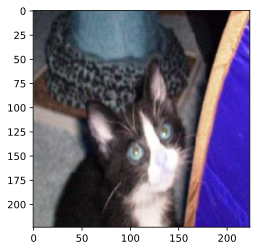

I am 93.22% sure this is a Cat


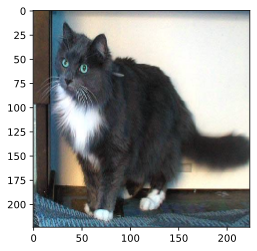

I am 52.27% sure this is a Dog


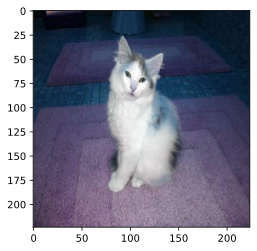

In [148]:
# Test out some predictions
predictions = model_3.predict(X_test, verbose=0)

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow((X_test[i]))
    plt.show()

# Model 4 evaluation

In [89]:
# Fit the model
# model = model()
start_time = time.time()
history = model_4.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,    
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks,
    verbose=2)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

# Saving models locally after fitting
save_dir = "results/"
model_name = 'keras_cnn_model_4.h5'
model_path = os.path.join(save_dir, model_name)
model_4.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

# # Final evaluation of the model
# # Loading saved model
# mnist_model = load_model('results/keras_mnist_model_4.h5')
# scores = mnist_model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/10
 - 75s - loss: 0.7847 - accuracy: 0.5562 - val_loss: 1.2591 - val_accuracy: 0.4961
Epoch 2/10
 - 70s - loss: 0.7121 - accuracy: 0.5918 - val_loss: 0.8034 - val_accuracy: 0.5972
Epoch 3/10
 - 74s - loss: 0.6534 - accuracy: 0.6351 - val_loss: 0.5697 - val_accuracy: 0.6726
Epoch 4/10
 - 73s - loss: 0.6233 - accuracy: 0.6726 - val_loss: 1.0114 - val_accuracy: 0.5278
Epoch 5/10
 - 73s - loss: 0.5886 - accuracy: 0.6947 - val_loss: 1.1006 - val_accuracy: 0.6052

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
 - 72s - loss: 0.5439 - accuracy: 0.7293 - val_loss: 0.6907 - val_accuracy: 0.7282
Epoch 7/10
 - 73s - loss: 0.5124 - accuracy: 0.7567 - val_loss: 0.6295 - val_accuracy: 0.7083
Epoch 8/10
 - 74s - loss: 0.5143 - accuracy: 0.7591 - val_loss: 0.5489 - val_accuracy: 0.6627

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/10
 - 70s - loss: 0.4847 - accuracy: 0.7822 - val_loss: 0.1818 - val_accuracy:

In [90]:
# Final evaluation of the model
scores = model_4.evaluate(validation_generator, verbose=0)
print('Testing scores:')
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Accuracy score: %.4f" % scores[1])
print("Loss: %.4f" % scores[0])

Testing scores:
Accuracy score: 0.7654
Loss: 0.6032


**Figure 10: Model 4 learning curves**

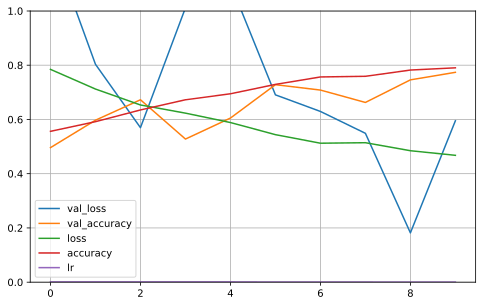

In [91]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**Figure 11: Model 4 learning curves**

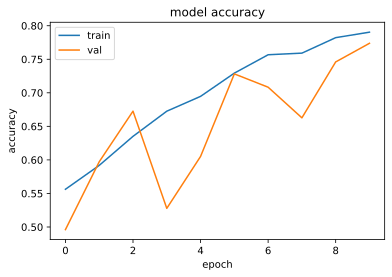

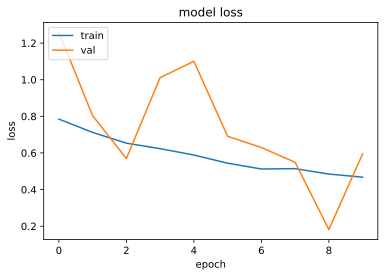

In [92]:
# Visualize results
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Kaggle submission

In [93]:
# Predict on test data
predictions = model_4.predict(X_test, verbose=0)

In [94]:
ids = range(1, len(X_test) + 1)
solution = pd.DataFrame({"id": ids, "label":list(predictions)})
cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
solution.to_csv("results/Sunday_CNN_4.csv", index = False)

Kaggle ID: clairence<br>
Kaggle score: 0.47515

<img src="CNN4.png">

**Figure 12: Model 4 test predictions**

I am 83.02% sure this is a Dog


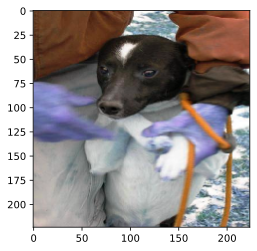

I am 94.02% sure this is a Dog


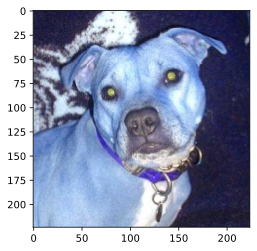

I am 88.90% sure this is a Cat


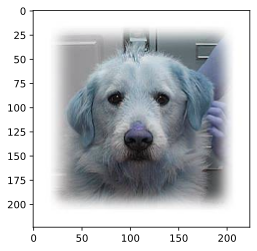

I am 99.97% sure this is a Dog


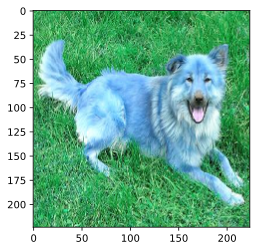

I am 78.68% sure this is a Cat


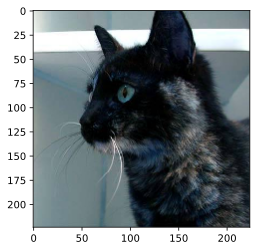

I am 64.37% sure this is a Cat


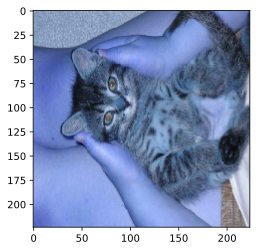

I am 74.81% sure this is a Cat


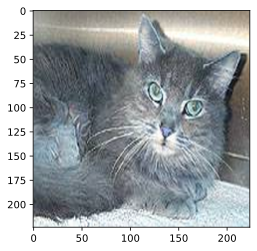

I am 58.50% sure this is a Cat


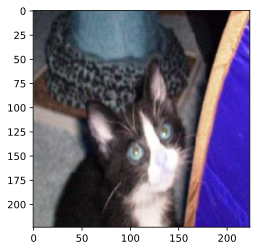

I am 88.23% sure this is a Cat


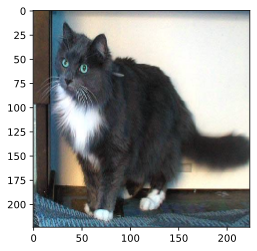

I am 53.93% sure this is a Cat


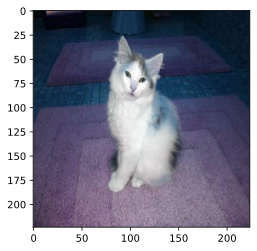

In [149]:
# Test out some predictions
predictions = model_4.predict(X_test, verbose=0)

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow((X_test[i]))
    plt.show()